In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
import geopandas as gpd
import folium
from h3 import h3
from scipy.linalg import toeplitz
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely import wkt, affinity
from shapely.wkt import loads
from branca.colormap import linear
from IPython.core.interactiveshell import InteractiveShell

# Set interactivity to all
InteractiveShell.ast_node_interactivity = "all"


C:\ProgramData\Anaconda3\envs\g_env\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [ ]:

zipdf = pd.read_csv('cejst_bp_zip_shp.csv')

zipdf['zip_geom'] = zipdf['zip_geom'].apply(wkt.loads)
zipdf = gpd.GeoDataFrame(zipdf, geometry = zipdf['zip_geom'], crs='epsg:4326')
zipdf = zipdf.round(2)


# Load the shapefile of counties from the US Census Bureau 
state_url = 'https://www2.census.gov/geo/tiger/TIGER2022/STATE/tl_2022_us_state.zip'
st_shp = gpd.read_file(state_url)
statedf = pd.read_csv('state_shp.csv')
st_shp = st_shp.merge(statedf, left_on='STUSPS', right_on='num_state', how='inner')


# 1.  Introduction


## 1.1 Current Policy Context 

https://www.bloomberg.com/news/articles/2023-05-11/biden-adopts-new-green-building-energy-standards-for-housing

## 1.2 Related literature and data

Over the past year, the Environmental Impact Data Collaborative has partnered with BlocPower - a Brooklyn-based climate technology company that uses building-level energy use data to guide community decarbonization projects. A key element of this partnership has been EIDC’s role in helping make BlocPower’s data available to researchers in the  environmental justice space.

BlocPower uploaded 3,309 data points for more than 121 million buildings to EIDC. This data is stored in Amazon Web Services and was transferred to Redivis using the built-in RestAPI. Additionally, this process occurred in two phases: first, BlocPower uploaded data for 39 states in January 2023, and second, they uploaded data for the additional 11 states and Washington D.C. in April 2023. This was ingested on MDI EIDC’s Google Cloud storage.

[Sources]

The source of this data is tax assessment records, which provide real data on building system types and attributes (like built year and area). This data then serves as inputs to an Automatic Building Energy Modeling (AutoBEM) developed by Oak Ridge National Laboratory


RECS

## 1.3 Data Availability


The data is made available through the following datasets on EIDC’s Redivis data repository:

**1. Core**: Individual building level data for 51 states and territories.

**2. Summary**: Aggregated ZCTA and county-level statistics.


The states marked in yellow have nearly all values missing for address, and the key building attributes like heating and cooling system types. This arises because the building attributes data could not be matched to an address. 
[PRESENT VALUES]


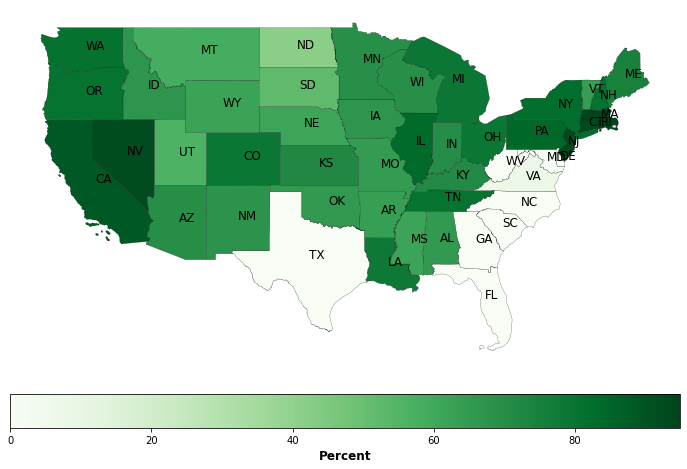

In [419]:
import matplotlib.colors as mcolors

st_shp['perc_nmiss'] = 100-st_shp['perc_miss']
# Set the size of the plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the data
st_shp.plot(column='perc_nmiss', cmap='Greens', linewidth=0.2, ax=ax, edgecolor='black')

# Annotate states with 'STUSPS' values
for x, y, label in zip(st_shp.geometry.centroid.x, st_shp.geometry.centroid.y, st_shp['STUSPS']):
    ax.text(x, y, label, fontsize=12)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=min(st_shp['perc_nmiss']), vmax=max(st_shp['perc_nmiss'])))
sm._A = []
cbar = fig.colorbar(sm, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('Percent', fontsize=12, fontweight='bold')

# Set the title
#ax.set_title('Fig 1. Percent of missing addresses by state', fontdict={'fontsize': '14', 'fontweight' : 'bold'})

# # Remove axis
ax.axis('off')

# Save the figure
#plt.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\miss_map.png', dpi=300)
plt.show();

## 2. Data Validation


## 2.1 Building counts: Microsoft Building Footprints 

We tried to assess the accuracy of the data by comparing aggregated statistics of buildings at the zip and county levels with other data sources. One such independent source of data on buildings is provided by Microsoft’s Building Footprints dataset [LINK]. This contains 129,591,852 building footprint polygon geometries for the US mainland in GeoJSON format, derived from computer vision algorithms on satellite imagery (updated till 2020). Figure 2 plots compares the number of buildings in the Microsoft and BlocPower datasets, aggregated to the zipcode level. 


<AxesSubplot:xlabel='build_counts', ylabel='tot_build'>

<AxesSubplot:xlabel='build_counts', ylabel='tot_build'>

Text(0.1, 0.8, 'Correlation: 0.93')

Text(0.5, 1.0, 'Comparing building counts in zipcodes')

Text(0.5, 0, 'Microsoft')

Text(0, 0.5, 'BlocPower')

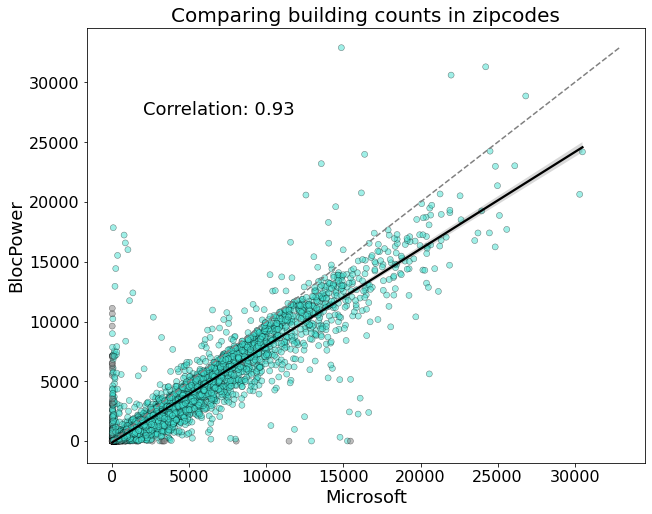

In [330]:


fig, ax = plt.subplots(figsize=(10, 8))

# Define the condition for the color
zipdf['color'] = np.where((zipdf['build_counts'] < 10) | (zipdf['tot_build'] < 10), 'grey', 'turquoise')

sns.scatterplot(data=zipdf, x='build_counts', y='tot_build', alpha=0.5,  hue='color',
                palette={'turquoise':'turquoise', 'grey':'grey'}, edgecolor='black', linewidth=0.5, ax=ax)

# Add a 45-degree line
max_value = max(zipdf['build_counts'].max(), zipdf['tot_build'].max())
ax.plot([0, max_value], [0, max_value], 'gray', linestyle='--')

# Fit a regression line using Seaborn's regplot
sns.regplot(data=zipdf, x='build_counts', y='tot_build', scatter=False, ax=ax, line_kws={"color": "black"})

# Calculate the correlation coefficient
corr_coef = zipdf['build_counts'].corr(zipdf['tot_build'])

# Print the correlation coefficient on the graph
ax.text(0.1, 0.8, f'Correlation: {corr_coef:.2f}', fontsize=18, transform=ax.transAxes)

# Set title and labels with increased font size
ax.set_title('Comparing building counts in zipcodes', fontsize=20)
ax.set_xlabel('Microsoft', fontsize=18)
ax.set_ylabel('BlocPower', fontsize=18)

# Increase font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

# Remove the legend
ax.get_legend().remove()

plt.show();
#plt.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\mic_val.png', dpi=300)

Note: Zipcode level statistics for six states - New York, Pennsylvania, Minnesota, Tennessee, Washington, Massachusetts, Colorado and Arizona



It shows a high correlation of 0.92, and the best-fit regression line is slightly below the 45-degree line, denoted by the dashed line. Note that expecting perfect equality would not be appropriate as the datasets were generated at different points in time. Additionally, there is a known rate of precision/recall error in the Microsoft dataset (in some cases,  water bodies and railway tracks are erroneously classified as containing buildings).



## 2.2 Energy Use Intensity: CoreLogic-RECS (Goldstein et al 2022) 


Goldstein et al (2022) used proprietary data from CoreLogic for around 90 million buildings to estimate energy use intensity (EUI). Using the primary heating fuel type and cooling type (AC) of the building from CoreLogic, they generate EUI estimates with the regression models trained on the Residential Energy Consumption Survey (RECS) 2015. Their findings are covered in a later section. They also make available zipcode level energy use intensity in slightl different unites (kWH/square meters). We calculate the weighted average of EUI for each county, weighted by zipcode population, and compare it with county level EUI estimates generated from the BlocPower data. 


<AxesSubplot:xlabel='mu_eui', ylabel='EUI'>

<AxesSubplot:xlabel='mu_eui', ylabel='EUI'>

Text(0.1, 0.8, 'Pearson Correlation: 0.46***')

Text(0.5, 1.0, 'Average County EUI - BLocPower vs. Goldstein (2022)')

Text(0.5, 0, 'Mean EUI (BlocPower) ')

Text(0, 0.5, 'Mean EUI (Goldstein)')

Note: Data for 741 matched counties. County level population-weighted average of EUI. 95-percentile outliers excluded. Pearson's correlation coefficient = 0.46. P-value = 0.0000


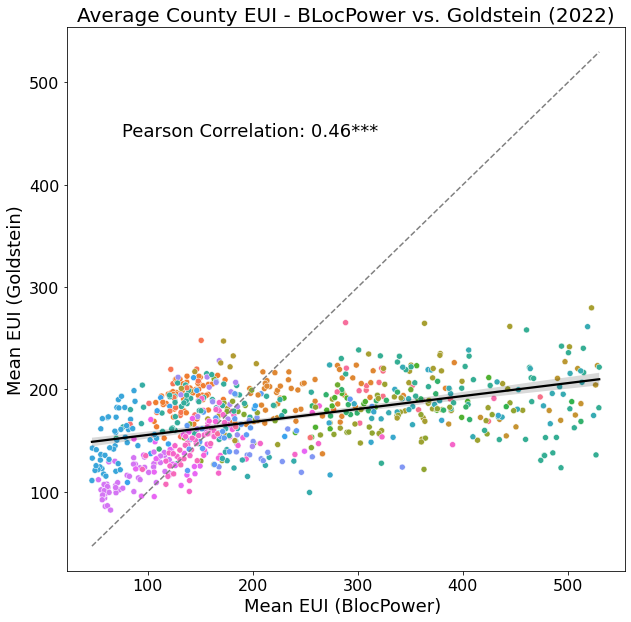

In [421]:

from scipy.stats import pearsonr

bp_gldstn2 = pd.read_csv('bp_gldstn.csv')

# Filter out upper 5% quantile of mu_eui
bp_gldstn = bp_gldstn2[bp_gldstn2.mu_eui < bp_gldstn2.mu_eui.quantile(.95)]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create scatterplot with color conditioning
sns.scatterplot(data=bp_gldstn, x='mu_eui', y='EUI', hue='STUSPS', ax=ax)

# Add a 45-degree line
min_value = min(bp_gldstn['mu_eui'].min(), bp_gldstn['EUI'].min())

max_value = max(bp_gldstn['mu_eui'].max(), bp_gldstn['EUI'].max())
ax.plot([min_value, max_value], [min_value, max_value], 'gray', linestyle='--')

# Fit a regression line using Seaborn's regplot
sns.regplot(data=bp_gldstn, x='mu_eui', y='EUI', scatter=False, ax=ax, line_kws={"color": "black"})

# Calculate the correlation coefficient
corr_coef, p_value = pearsonr(bp_gldstn['mu_eui'], bp_gldstn['EUI'])

# Print the correlation coefficient on the graph
ax.text(0.1, 0.8, f'Pearson Correlation: {corr_coef:.2f}***', fontsize=18, transform=ax.transAxes)

# Set title and labels with increased font size
ax.set_title('Average County EUI - BLocPower vs. Goldstein (2022)', fontsize=20)
ax.set_xlabel('Mean EUI (BlocPower) ', fontsize=18)
ax.set_ylabel('Mean EUI (Goldstein)', fontsize=18)

# Increase font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

# Remove the legend
ax.get_legend().remove()


plt.show();

# Add a note below the figure
print(f"Note: Data for 741 matched counties. County level population-weighted average of EUI. 95-percentile outliers excluded. Pearson's correlation coefficient = {corr_coef:.2f}. P-value = {p_value:.4f}");

#fig.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\gld_val.png', dpi=300)


The figure clearly shows a high Spearman's correlation coefficient of 0.46, though the points are nowhere near the 45-degree line of equality. The different units, and lapse of time between the datasets makes this unlikely. Note that this dataset does not follow the cleaning steps done by Goldstein (restricting to Single Family only, and minimum and maximum area thresholds)

KS statistic: 0.3405889884763124
p-value: 1.5268914209059102e-40


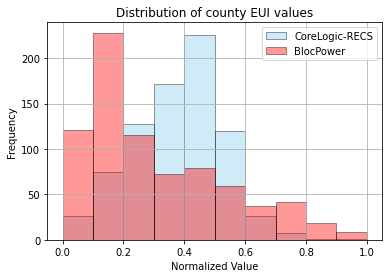

In [169]:


ks_statistic, p_value = stats.ks_2samp(bp_gldstn2['EUI_norm'], bp_gldstn2['mu_eui_norm'])

print('KS statistic:', ks_statistic)
print('p-value:', p_value)

# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the 'EUI' column
bp_gldstn2['EUI_norm'] = scaler.fit_transform(bp_gldstn2[['EUI']])

# Fit and transform the 'mu_eui' column
bp_gldstn2['mu_eui_norm'] = scaler.fit_transform(bp_gldstn2[['mu_eui']])

# Now, you can plot the histograms and calculate the KS statistic:

bp_gldstn2['EUI_norm'].hist(color='skyblue', alpha=0.4, label='CoreLogic-RECS', edgecolor='black')
bp_gldstn2['mu_eui_norm'].hist(color='red', alpha=0.4, label='BlocPower', edgecolor='black')

plt.title('Distribution of county EUI values')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.legend()

plt.show();


A small p-value (typically less than 0.05) suggests that the two distributions are significantly different. However, keep in mind that the KS test makes no assumptions about the specific form of the distribution (it's a nonparametric test), so it is not sensitive to differences in, for example, the means or variances of the distributions.

# 3. Exploratory Data Analysis


## 3.1 Map of median building EUI across zipcode

The following maps depicts the median energy use intensity across all buildings in each zipcode. As we see, data is missing for certain zipcodes and states, which appear in grey. There seems to be considerable variation in EUI, and we see that the highest EUI values are in the Northeast.

<AxesSubplot:>

[Text(3, 3, 'WV'),
 Text(3, 3, 'FL'),
 Text(3, 3, 'IL'),
 Text(3, 3, 'MN'),
 Text(3, 3, 'MD'),
 Text(3, 3, 'RI'),
 Text(3, 3, 'ID'),
 Text(3, 3, 'NH'),
 Text(3, 3, 'NC'),
 Text(3, 3, 'VT'),
 Text(3, 3, 'CT'),
 Text(3, 3, 'DE'),
 Text(3, 3, 'NM'),
 Text(3, 3, 'CA'),
 Text(3, 3, 'NJ'),
 Text(3, 3, 'WI'),
 Text(3, 3, 'OR'),
 Text(3, 3, 'NE'),
 Text(3, 3, 'PA'),
 Text(3, 3, 'WA'),
 Text(3, 3, 'LA'),
 Text(3, 3, 'GA'),
 Text(3, 3, 'AL'),
 Text(3, 3, 'UT'),
 Text(3, 3, 'OH'),
 Text(3, 3, 'TX'),
 Text(3, 3, 'CO'),
 Text(3, 3, 'SC'),
 Text(3, 3, 'OK'),
 Text(3, 3, 'TN'),
 Text(3, 3, 'WY'),
 Text(3, 3, 'ND'),
 Text(3, 3, 'KY'),
 Text(3, 3, 'ME'),
 Text(3, 3, 'NY'),
 Text(3, 3, 'NV'),
 Text(3, 3, 'MI'),
 Text(3, 3, 'AR'),
 Text(3, 3, 'MS'),
 Text(3, 3, 'MO'),
 Text(3, 3, 'MT'),
 Text(3, 3, 'KS'),
 Text(3, 3, 'IN'),
 Text(3, 3, 'SD'),
 Text(3, 3, 'MA'),
 Text(3, 3, 'VA'),
 Text(3, 3, 'IA'),
 Text(3, 3, 'AZ')]

<AxesSubplot:>

(-127.7471505, -63.98726750000001, 23.14689945, 50.63388755)

[]

[]

Text(0.5, 1.0, 'Zip level EUI (state-normalized)')

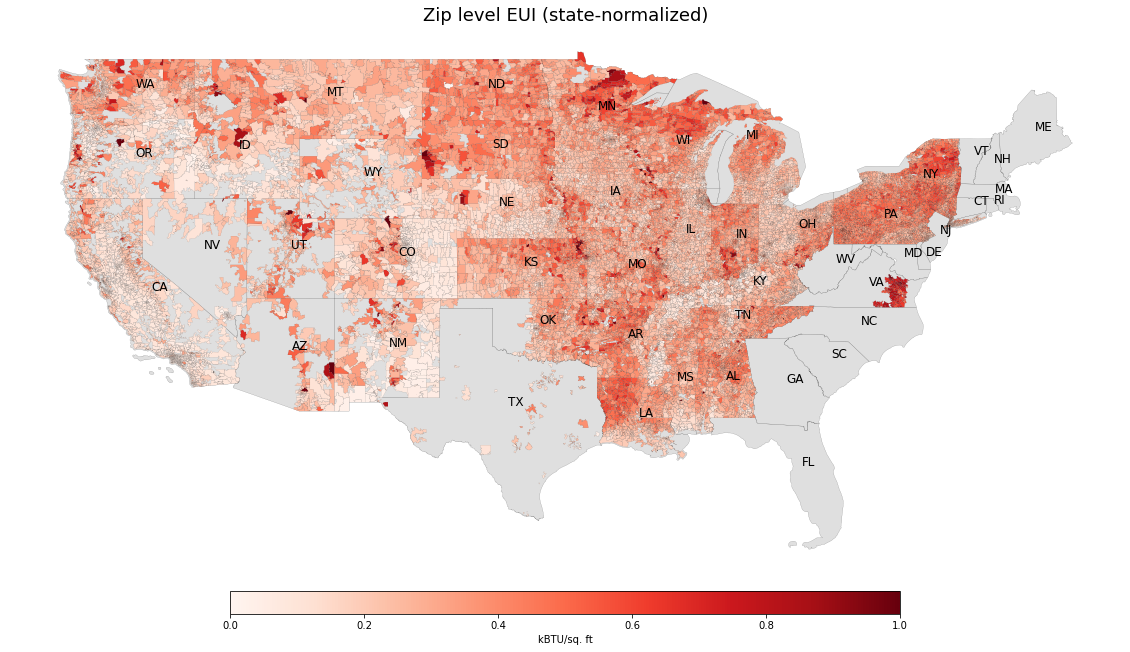

In [422]:
st_shp = st_shp.rename(columns={"GEOID": "st_code",
                                "geometry": "st_geom"})

# DROP ALASKA, HAWAII
st_shp = st_shp[~(st_shp.STUSPS.isin(
    ['AK', 'HI', 'AS', 'VI', 'MP', 'VI', 'PR', 'GU']))]

# zip_shp = zip_shp[['zip_name', 'zip_fips', 'geometry']]
st_shp = gpd.GeoDataFrame(st_shp, geometry='st_geom', crs='epsg:4326')

zipdf['mean_eui_normalized'] = zipdf.groupby('state_code')['mean_eui'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()))


fig, ax = plt.subplots(figsize=(20, 16))

st_shp.plot(ax=ax, edgecolor='k', alpha=0.5, linewidth=0.2, color="silver")

# Increase the fontsize for the state annotations
[plt.annotate(row['STUSPS'], 
              xy=(row['st_geom'].centroid.x, row['st_geom'].centroid.y), 
              xytext=(3, 3), textcoords='offset points', color='black', 
              fontsize=12)  # Increase the fontsize here
 for idx, row in st_shp.iterrows()]

zipdf.plot(column='mean_eui_normalized', ax=ax, alpha=1,
           cmap='Reds', linewidth=0.05, edgecolor='black', legend=True,
           legend_kwds={"label": "kBTU/sq. ft", 
                         "orientation": "horizontal", 
                         "shrink": 0.6, 
                         "aspect": 30,  # Adjust the length of legend
                         "pad": 0.02,   # Adjust the space between the plot and the legend
                         "fraction": 0.046,  # Adjust the height of the legend
                       })  # Increase the fontsize for the colorbar ticks here

plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Zip level EUI (state-normalized)', fontsize=18)

ax.tick_params(labelsize=18)

#ax.set_label('Reporting Year', size=16)


plt.show();
#fig.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\eui_map.png', dpi=300)

## 3.2 Top heating system type by zipcode - Colorado

We calcuate the most common heating system type, by choosing the heating system with the highest share of buildings in a zipcode. The map for Colorado is given below. In case policymakers want to target particular kinds of heating systems, say, baseboard heating, they can identify and locate areas with a high prevalence.

<AxesSubplot:>

[]

[]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

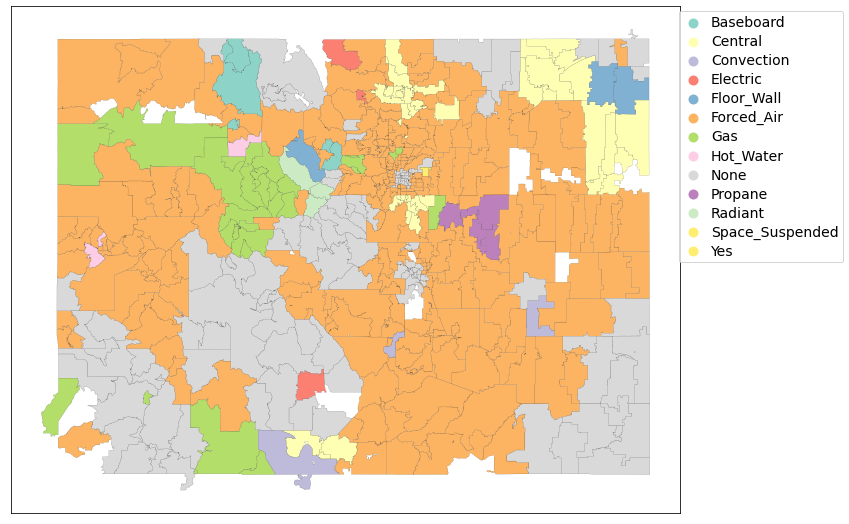

In [425]:
ar_df= zipdf[(zipdf.state_code=='CO')]

fig, ax = plt.subplots(figsize=(12, 12))



ar_df.plot(column='TOP_heat_system', ax=ax, alpha=1,
           cmap='Set3', linewidth=0.1, edgecolor='black', legend=True)


#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('Most common heating system type - Colorado', fontsize=20)
# Place the legend to the right of the figure
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.25,1))
plt.setp(leg.get_texts(), fontsize=14)
# ax.set_title("My Plot", fontsize=18)
plt.show();
#fig.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\co_heat.png', dpi=300, 
            #bbox_inches='tight', bbox_extra_artists=(leg,))

## 3.3 Energy Use by heating technology


The uniquely granular nature of the data can be leveraged to create detailed energy source and destination diagrams for heating fuel/system types. The interactive Sankey plot below allows you to examine the energy breakdown (total site energy use in GJ) for different states.


In [314]:
%%capture

df_agg = pd.read_csv('state_heat_fuel_sankey.csv')

df_agg = df_agg[~(df_agg.state.isin(['WV', 'MD', 'DE', 'NC', 'GA', 'VT', 'LA', 'DC', 'SC', 'FL']))]

# Group by heating_fuel_type and heating_system_type and calculate the sum
df_us = df_agg.groupby(['heating_fuel_type', 'heating_system_type'])[
    'total_site_energy', 'total_source_energy'].sum().reset_index()

# Add a new column 'state' and set its value to 'US'
df_us['state'] = 'US'

# Append df_us to df_agg
df_agg = pd.concat([df_agg, df_us])

# Get the list of unique states
states = df_agg['state'].unique().tolist()

# Create an empty figure
fig = go.Figure()

# Define a function to create a Sankey diagram for a specific state
def create_sankey(state):
    df_state = df_agg[df_agg['state'] == state]
    fuel_types = df_state['heating_fuel_type'].unique().tolist()
    system_types = df_state['heating_system_type'].unique().tolist()
    labels = fuel_types + system_types
    sources = [labels.index(fuel_type) for fuel_type in df_state['heating_fuel_type']]
    targets = [labels.index(system_type) for system_type in df_state['heating_system_type']]
    values = df_state['total_source_energy'].tolist()
    colors = ['blue' for _ in fuel_types] + ['green' for _ in system_types]

    # Create a Sankey diagram trace for the state
    sankey = go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    )

    return sankey

# Create a Sankey diagram trace for each state and add them to the figure
for state in states:
    sankey_trace = create_sankey(state)
    fig.add_trace(sankey_trace.update(visible=False))

# Create a dropdown menu
dropdown_buttons = [
    dict(
        args=[{"visible": [state == s for state in states]}],
        label=s,
        method="update"
    )
    for s in states
]

# Update the layout
fig.update_layout(
    updatemenus=[
        dict(
            buttons=dropdown_buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ],
    title_text="Heating fuel type and system types - Source Energy Use (GJ)",
    font_size=10
)

# Initially, show the Sankey diagram for the first state
fig.data[0].visible = True
;


In [315]:
fig.show()

    # bad states - 'WV', 'MD', 'DE', 'NC', 'GA', 'VT', 'LA', 'DC', 'SC', 'FL'

## 4. A quantitative framework for energy efficiency and justice


Helleno et al (2022) outline a new approach to maximise energy efficiency through interventions with social justice. Here, we sketch a simple implementation of such a framework, by overlaying the Climate and Economic Justice Screening Tool (CEJST). Using a method, we generate the proportion of population in each zipcode which lives in a tract classified as disadvantaged in the CEJST. The other variable in the framework will be the percent of buildings in each zipcode classified as having either high or medium energy efficiency potential (EEP) by BlocPower.

We select the state of Kentucky to illustrate this analysis. Fig plots the share of disadvantaged population on the Y-Axis and percent of buildings with medium-high EEP on the X-Axis.  Partly, this graph is inspired, but different, from the quadrant analysis performed in Tong et al (2021). 

Depending on the threshold of each variable chosen, a different set of zipcodes fall in the 'optimal zone' of interventions. The interactive plot below allows different X and Y thresholds to be set, selecting a different set of zipcodes each time.

<AxesSubplot:xlabel='ee_hi_med', ylabel='PCT_DISADVANTAGED'>

Text(0.5, 0, '% of buildings with medium-high EEP')

Text(0, 0.5, 'Prop. of zipcode pop. in disadvantaged tracts')

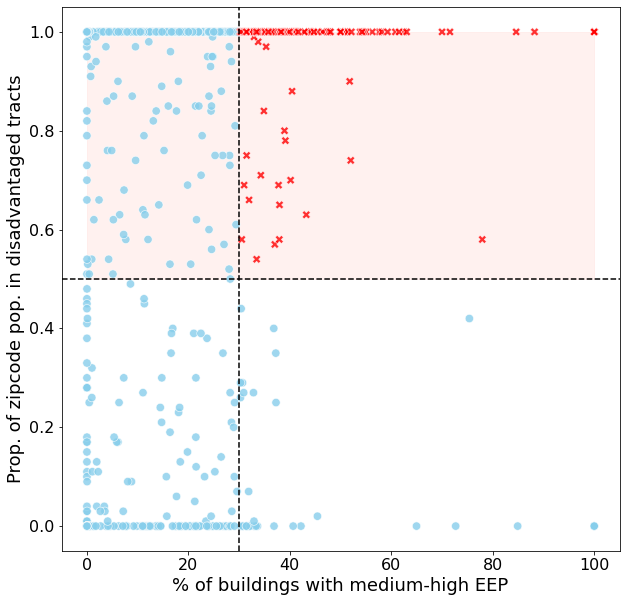

In [427]:

zipdf['ee_hi_med'] = zipdf.perc_total_ee_potential_score_EE_HIGH + zipdf.perc_total_ee_potential_score_EE_MED
zipdf = zipdf.round(2)

ky_df= zipdf[(zipdf.state_code=='KY')]

# Define the condition for the color
ky_df['chosen'] = np.where(
    (ky_df['PCT_DISADVANTAGED'] > 0.5) & (ky_df['ee_hi_med'] > 30), 1, 0)

fig, ax = plt.subplots(figsize=(10, 10))

# Draw horizontal and vertical lines at the median of the data
ax.axvline(30,  color='black', linestyle='--')
ax.axhline(.5,  color='black', linestyle='--')

# Fill the area above y > 0.5
ax.fill_betweenx([0.5, max(ky_df['PCT_DISADVANTAGED'])], 
                 min(ky_df['ee_hi_med']), 
                 max(ky_df['ee_hi_med']), 
                 color='mistyrose', 
                 alpha=0.5)

# Create a scatterplot
sns.scatterplot(data=ky_df, s=70,
                x='ee_hi_med',
                y='PCT_DISADVANTAGED',
                style='chosen',
                alpha=0.8,
                hue='chosen',
                palette={1:'red', 0:'skyblue'},  # Map the colors
                legend=False)  # No legend

# Set x and y labels
ax.set_xlabel('% of buildings with medium-high EEP', fontsize=18)  # x-axis label
ax.set_ylabel('Prop. of zipcode pop. in disadvantaged tracts', fontsize=18)  # y-axis label

# Increase font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show();
#fig.savefig(r'quad1.png', dpi=300, 
          #  bbox_inches='tight')

In [318]:

warnings.filterwarnings('ignore')

# Define the function to update the figure
def update_figure(x_value, y_value):
    # Define the condition for the color
    ky_df['chosen2'] = np.where((ky_df['PCT_DISADVANTAGED'] > y_value) & (ky_df['ee_hi_med'] > x_value), 1, 0)

    color_dict = {0: 'blue', 1: 'red'}
    ky_df['color'] = ky_df['chosen2'].map(color_dict)

    # Create hover text
    hover_text = []
    for index, row in ky_df.iterrows():
        hover_text.append(('Zip: {zipcode}<br>' +
                           'Average EUI: {aveui}').format(zipcode=row['zipcode'],
                                                aveui=row['mean_eui']))

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=ky_df['ee_hi_med'],
            y=ky_df['PCT_DISADVANTAGED'],
            mode='markers',
            marker=dict(
                color=ky_df['color'],
                size=7,
                line=dict(
                    color='black',
                    width=.5
                )
            ),
            text=hover_text,  # Update this line
            hoverinfo='text'  # Update this line
        )
    )

    fig.add_shape(
        type='line',
        yref='paper', y0=0, y1=1,
        xref='x', x0=x_value, x1=x_value
    )

    fig.add_shape(
        type='line',
        xref='paper', x0=0, x1=1,
        yref='y', y0=y_value, y1=y_value
    )

    fig.update_layout(
        xaxis_title='% of buildings with medium-high EEP',
        yaxis_title='Prop. disadvantaged',
        showlegend=False,
        width=700,
        height=700,
        plot_bgcolor='white'   # set plot background color to white
     #   paper_bgcolor='white'
    )
    
    fig = fig.add_hrect(y0=y_value, y1=1, line_width=0, fillcolor="salmon", opacity=0.2)

    fig.show()

# Define the widgets
x_slider = widgets.FloatSlider(min=0, max=100, step=5, value=30, description='% EEP')
y_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='% Disadv')

# Display the widgets and the interactive plot
widgets.interact(update_figure, x_value=x_slider, y_value=y_slider)


interactive(children=(FloatSlider(value=30.0, description='% EEP', step=5.0), FloatSlider(value=0.5, descripti…

<function __main__.update_figure(x_value, y_value)>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(801   -88.47514
dtype: float64, 801    38.333174
dtype: float64, 'Madisonville, Zip 42344')

(-89.78050605, -81.59261095, 36.364762500000005, 39.2752635)

[]

[]

Text(0.5, 1.0, 'Selected Zipcodes with high disadvantage + EEP - Kentucky')

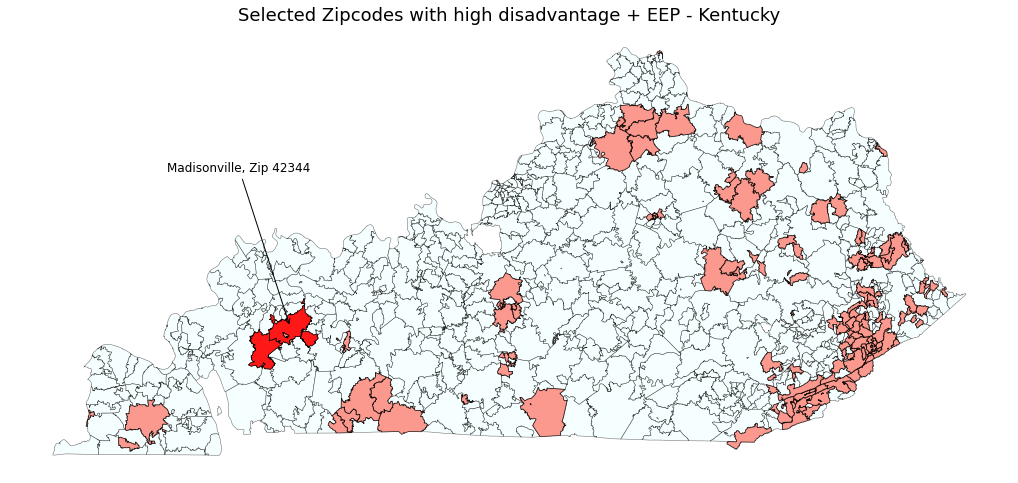

In [429]:

zipcodes = [42431, 42408, 42344]


ky_df['chosen'] = np.where(
    ky_df['zipcode'].isin(zipcodes), 2, ky_df['chosen'])

                            
fig, ax = plt.subplots(figsize=(18, 14))

ky_df[ky_df['chosen'] == 0].plot(
    ax=ax, color='azure', linewidth=0.5, edgecolor='black', alpha=0.6)
ky_df[ky_df['chosen'] == 1].plot(
    ax=ax, color='salmon', linewidth=0.8, edgecolor='black', alpha=0.8)
ky_df[ky_df['chosen'] == 2].plot(
    ax=ax, color='red', linewidth=0.8, edgecolor='black', alpha=0.9)
        

# Get the centroids of the polygons for the specified zip codes
centroid = ky_df[ky_df['zipcode'] == 42431].geometry.centroid
ax.annotate(f"Madisonville, Zip {zipcode}", (centroid.x, centroid.y), 
                xytext=(centroid.x -1, centroid.y + 1), 
                arrowprops=dict(facecolor='black', arrowstyle="->"),  fontsize=12)

    
plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(
    'Selected Zipcodes with high disadvantage + EEP - Kentucky', fontsize=18)
plt.show();

# fig.savefig(r'D:\Work\Georgetown\acad\mdi\summer_research\bp\ky_zips.png', dpi=300, 
#             bbox_inches='tight')


Once a set of zipcodes has been chosen, we can mark them and visualize on a map. It is interesting to note the that many zipcodes are distributed as local spatial clusters. For this illustrative analysis, suppose we choose zipcodes - 42431, 42408, 42344 - in Madisonville, Kentucky. We now retrieve the original individual building level data for these three zipcodes from EIDC, and geocode the buildings.

## Spatial clustering of high EUI buildings - H3 indexing

Here, we use Uber's open source H3 indexing method to find spatial clusters of buildings with high EUI (defined as EUI above the zipcode's median).

In [319]:

# # Convert the DataFrame to GeoDataFrame
# gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# # # Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
# # gdf.crs = "EPSG:3857"


# Load table as a DataFrame
gdf = pd.read_csv("geocoded_kentucky_zip_buildings.csv")

# Convert the 'geometry' column to Shapely geometries
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

# Assuming that your DataFrame has a 'geometry' column with Point geometries
gdf['lon'] = gdf['geometry'].apply(lambda geom: geom.y)
gdf['lat'] = gdf['geometry'].apply(lambda geom: geom.x)

# Create a new GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.lon, gdf.lat))



In [320]:

def update_map(h3_level):
    def lat_lng_to_h3(row):
        return h3.geo_to_h3(row.geometry.y, row.geometry.x, h3_level)

    gdf['h3'] = gdf.apply(lat_lng_to_h3, axis=1)

    counts = gdf[gdf['energy_use_intensity'] > np.median(gdf['energy_use_intensity'])].groupby('h3').size().reset_index(name='count')
    
    def add_geometry(row):
        points = h3.h3_to_geo_boundary(row['h3'], True)
        return Polygon(points)

    counts['geometry'] = counts.apply(add_geometry, axis=1)
    ky_hex = gpd.GeoDataFrame(counts, geometry='geometry', crs='EPSG:4326')

    m = folium.Map(location=[37.3, -87.56], zoom_start=11)

    colormap = linear.YlOrRd_09.scale(ky_hex['count'].min(), ky_hex['count'].max())

    folium.GeoJson(
        ky_hex,
        name='geojson',
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties']['count']),
            'color': 'black',
            'weight': .8,
            'fillOpacity': 0.7,
        },
        tooltip=folium.GeoJsonTooltip(fields=['count'])
    ).add_to(m)

    colormap.add_to(m)

    return m

interact(update_map, h3_level=widgets.IntSlider(min=1, max=11, step=1, value=9, description='H3 level:'))


interactive(children=(IntSlider(value=9, description='H3 level:', max=11, min=1), Output()), _dom_classes=('wi…

<function __main__.update_map(h3_level)>